<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_RNN_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [3]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20

In [4]:
class ManillaRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(ManillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.i2h = nn.Linear(embedding_dim, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, vocab_size)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))

  def forward(self, x):
    h = torch.zeros(1, self.hidden_size)
    y_list = []
    for i in range(x.shape[1]):
      t = self.embedding(x[:,i])
      h = torch.tanh(self.i2h(t) + self.h2h(h) + self.hb2)
      y = self.h2o(h) + self.ob
      y_list.append(y)
    return torch.stack(y_list, dim=1);

criterion = nn.CrossEntropyLoss()

model = ManillaRNN(vocab_size, embedding_dim, hidden_size)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

Now tusi ManillaRNN is different with the VanillaRNN.
It will iterate all the time step, drop the intermediate output, and only output the final one.

But I am not going to rewrite the training function to retrain the new model.
Because I think the VanillaRNN is more better and controlable than this one.


In [5]:
def getBatch():
  batch_inputs = []
  batch_targets = []

  start_idx = torch.randint(len(data) - seq_length - 2,[1]).item()

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [6]:
stopi = []
lossi = []

In [7]:
# Training loop
num_iterations = 10000
for iteration in range(num_iterations):

  inputs, targets = getBatch()
  predicts = model(inputs)
  optimizer.zero_grad()
  B,T = targets.shape

  totalloss = criterion(predicts.view(B*T, -1), targets.view(B*T))
  totalloss.backward()
  optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {totalloss}')
    stopi.append(iteration)
    lossi.append(totalloss.item())


Iteration 0, Loss: 4.191685676574707
Iteration 1000, Loss: 2.4839775562286377
Iteration 2000, Loss: 2.1040613651275635
Iteration 3000, Loss: 2.0516302585601807
Iteration 4000, Loss: 1.7573446035385132
Iteration 5000, Loss: 2.067279100418091
Iteration 6000, Loss: 1.7331370115280151
Iteration 7000, Loss: 1.737089991569519
Iteration 8000, Loss: 1.7116087675094604
Iteration 9000, Loss: 2.009890079498291


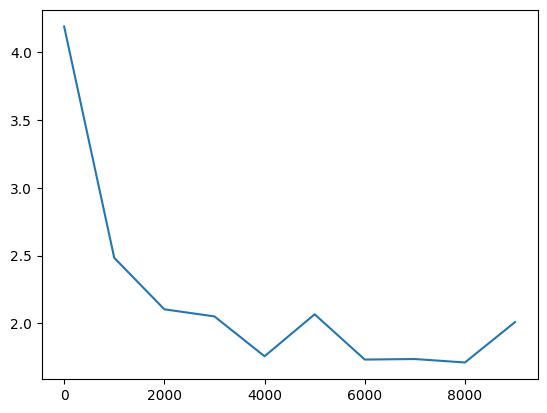

In [8]:
plt.plot(stopi, lossi)

In [33]:
with torch.no_grad():

  start = ['F','i','r','s','t']
  result = ['F','i','r','s','t']

  for i in range(1000):
    start = start[-seq_length:]
    ilist = torch.tensor([char_to_ix[i] for i in start])
    ilist = ilist.reshape(1, -1)
    outputs = model(ilist)

    p = nn.functional.softmax(outputs[:,-1,:], dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    start.append(ix_to_char[ix])
    result.append(ix_to_char[ix])

  print(''.join(result))


First I seave aptouny fro gever, you dake the thouse but be overou made rook.

KETHARUS:
Petand is achath.

Grester your faster trough not, you is more it,
Thishys, Long and sust,
eid, fach fordact and not Tomfor ere man have I siter, Fold for mathink a 'ging bodes
Io which
pinttunes then's not Bay. II:
Should to thou thwet.

PRNrATYATESO:
My behath grabye
The ks at thy the tidds rive
A duns;

CEYIO:
Dite.

SATUL:
I so; the mast ay gust by.

Mar, arp
alb.

Picks chelt!

GRUCEY:
So the by froscour sired I wens cind, Iath arions:
Bew groscelon's;
And bith Ause a sather that the cullos
Sis trupts.

AUTIO:
Should end a licks,
ATh folde love thou shood evenst you work them-yiers of wagger,
Os the with for tor her faee,--Of in havr. Lo and witht did a pids redyow'd the utserqease, En straintionguly the wave shall arious fair crown 'tourst nare the nesion; not it meeth ofs, whr,
What shall you.
For stands,
Bother it.

Secoman rore are is are his for I'll thouguich,
I drang:
No park! which I g

Since the RNN is better for seq to seq.but it also better for seq to 1.
In the above example, it is actually a example of seq to 1.
The thing is that, I only use the last output of the node as the result of the rnn.

I am not sure what if I stack all the outputs of the nodes, and squeese them tegether to get the final result is better or not. will continue to explore.

I think there is also another way to optimize the above model.
When I train the model, I prepare my data like this, the input is a list of characters, the expected output is one character.
but we could also prepare data like this, the input a list of characters, the expect result is also a list of character, but with one step shift.
but when generating data, I could just use the last character as the result.

I will try the last one later.

The new idea is that.

I always use the last time step as the final output of the RNN, or as the predict character of the previous input. we could go further as that, add attention in the final step, to focus differently on the previous tokens to decide what to predict, let do that.